In [1]:
import os
import sys
import random
sys.path.append("../")

import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from utils import file_util

In [2]:
DATA_DIR = "../data"
NAME_MENTION_DIR = os.path.join(DATA_DIR, "reuters_name_mentions")
entity_labels = file_util.load_json(os.path.join(DATA_DIR, "entity_labels.json"))

In [3]:
def create_concept_graph(file_name):
    base_name = os.path.splitext(file_name)[0]
    parent_path = base_name + "_parents.json"
    parents = file_util.load_json(parent_path)
    doc_id = base_name.split("/")[-1]
    
    graph = nx.DiGraph()
    for name_mention_eid, entity in parents.items():
        for parent in entity["parents"]:
            path = parent["path"].split(" >> ")
            nx.add_path(graph, path)
    
    num_nodes_before = len(graph.nodes)
    
    # Graph reduction
    largest_component_nodes = max(nx.connected_components(graph.to_undirected()), key=len)
    graph = graph.subgraph(largest_component_nodes)
    # Prune nodes
    node_central_scores = nx.algorithms.centrality.information_centrality(graph.to_undirected())
    min_central_score = pd.Series(node_central_scores.values()).quantile(.7u)
    central_nodes = [node for node, score in node_central_scores.items() if score >= min_central_score]
   
    graph = graph.subgraph(central_nodes)
    num_nodes_after = len(graph.nodes)
    return num_nodes_before, num_nodes_after, graph

In [4]:
file_names = file_util.get_file_name_in_dir(NAME_MENTION_DIR, "txt")
sample_file_name = random.sample(file_names, 1)[0]

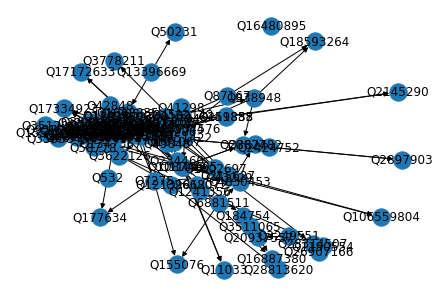

In [5]:
num_nodes_before, num_nodes_after, sample_graph = create_concept_graph(sample_file_name)
nx.draw(sample_graph, with_labels=True)
nx.write_edgelist(sample_graph, "sample_graph_edgelist.gz")

In [7]:
GRAPH_DIR = os.path.join(DATA_DIR, "graphs")
os.mkdir(GRAPH_DIR)
pbar = tqdm(file_names, desc="Creating concept graphs")

for file_name in pbar:
    base_name = os.path.splitext(file_name)[0]
    doc_id = base_name.split("/")[-1]
    try:
        num_nodes_before, num_nodes_after, graph = create_concept_graph(file_name)
    except:
        num_nodes_before, num_nodes_after = None, None
        graph = nx.DiGraph()
        
    graph_path = os.path.join(GRAPH_DIR, f"{doc_id}_graph_edgelist.gz")
    nx.write_edgelist(graph, graph_path)
    pbar.set_postfix({"reduce": f"{num_nodes_before}->{num_nodes_after}"})

Creating concept graphs: 100%|██████████| 10788/10788 [1:18:56<00:00,  2.28it/s, reduce=974->168]   
